In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiments/val.csv
/kaggle/input/sentiments/train.csv
/kaggle/input/sentiments/test.csv


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score
from sklearn.preprocessing import LabelEncoder
from torch.nn import functional as F
from collections import Counter

from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
# import optuna

In [ ]:
# train_df = pd.read_csv('/kaggle/input/sentiments/train.csv')
# val_df = pd.read_csv('/kaggle/input/sentiments/val.csv')
# test_df = pd.read_csv('/kaggle/input/sentiments/test.csv')

train_df = pd.read_csv('data/train.csv')
val_df = pd.read_csv('data/val.csv')
test_df = pd.read_csv('data/test.csv')

def tokenize(text):
    return word_tokenize(text.lower())

train_texts = train_df['text'].tolist()
train_labels = train_df['label'].tolist()

val_texts = val_df['text'].tolist()
val_labels = val_df['label'].tolist()

test_texts = test_df['text'].tolist()
test_labels = test_df['label'].tolist()

label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_labels)
val_labels = label_encoder.transform(val_labels)
test_labels = label_encoder.transform(test_labels)

In [ ]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\acer\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:
all_texts = train_texts + val_texts + test_texts
tokenized_texts = [tokenize(text) for text in all_texts]

word_counts = Counter([word for sentence in tokenized_texts for word in sentence])
vocab = {word: idx+2 for idx, (word, _) in enumerate(word_counts.most_common())}
vocab['<PAD>'] = 0
vocab['<UNK>'] = 1

def text_to_sequence(text, vocab):
    return [vocab.get(word, vocab['<UNK>']) for word in tokenize(text)]

train_sequences = [text_to_sequence(text, vocab) for text in train_texts]
val_sequences = [text_to_sequence(text, vocab) for text in val_texts]
test_sequences = [text_to_sequence(text, vocab) for text in test_texts]

def pad_sequences(sequences, max_len=100):
    return [seq[:max_len] + [0] * (max_len - len(seq)) if len(seq) < max_len else seq[:max_len] for seq in sequences]

train_sequences = pad_sequences(train_sequences)
val_sequences = pad_sequences(val_sequences)
test_sequences = pad_sequences(test_sequences)

X_train = torch.tensor(train_sequences, dtype=torch.long)
y_train = torch.tensor(train_labels, dtype=torch.long)
X_val = torch.tensor(val_sequences, dtype=torch.long)
y_val = torch.tensor(val_labels, dtype=torch.long)
X_test = torch.tensor(test_sequences, dtype=torch.long)
y_test = torch.tensor(test_labels, dtype=torch.long)


batch_size = 16
train_data = TensorDataset(X_train, y_train)
val_data = TensorDataset(X_val, y_val)
test_data = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

In [ ]:
len(vocab)

33144

In [12]:
class BiLSTMEncoder(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers=1):
        super(BiLSTMEncoder, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embed_size)

        self.bilstm = nn.LSTM(embed_size, hidden_size, num_layers=num_layers,
                               bidirectional=True, batch_first=True)

    def forward(self, x):
        x = self.embedding(x)

        lstm_out, (hn, cn) = self.bilstm(x) , (hn, cn)

        hidden_state = torch.cat((hn[0], hn[1]), dim=1)

        return hidden_state

In [13]:
class BiLSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_size=100, hidden_size=128, num_classes=2, num_layers=1):
        super(BiLSTMModel, self).__init__()


        self.encoder = BiLSTMEncoder(vocab_size, embed_size, hidden_size, num_layers)


        self.fc = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x):

        hidden_state = self.encoder(x)


        out = self.fc(hidden_state)

        return out

In [14]:
!pip install torchinfo

In [18]:
from torchinfo import summary
model = BiLSTMModel(33144, embed_size=50, hidden_size=128, num_classes=2, num_layers=1)
summary(model, input_size=(16,100), dtypes= [torch.long])


Layer (type:depth-idx)                   Output Shape              Param #
BiLSTMModel                              [16, 2]                   --
├─BiLSTMEncoder: 1-1                     [16, 256]                 --
│    └─Embedding: 2-1                    [16, 100, 50]             1,657,200
│    └─LSTM: 2-2                         [16, 100, 256]            184,320
├─Linear: 1-2                            [16, 2]                   514
Total params: 1,842,034
Trainable params: 1,842,034
Non-trainable params: 0
Total mult-adds (M): 321.44
Input size (MB): 0.01
Forward/backward pass size (MB): 3.92
Params size (MB): 7.37
Estimated Total Size (MB): 11.30

In [ ]:
def train(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0
    for texts, labels in train_loader:
        texts, labels = texts.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(texts)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total
    return total_loss / len(train_loader), train_acc

def evaluate(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    val_preds = []
    val_labels = []

    with torch.no_grad():
        for texts, labels in val_loader:
            texts, labels = texts.to(device), labels.to(device)
            outputs = model(texts)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            val_preds.extend(predicted.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    val_accuracy = correct / total
    val_f1 = f1_score(val_labels, val_preds, average='weighted')
    val_recall = recall_score(val_labels, val_preds, average='weighted')

    return val_loss / len(val_loader), val_accuracy, val_f1, val_recall

def train_and_evaluate(model, train_loader, val_loader, optimizer, criterion, device, epochs=10, patience=3):
    best_val_acc = 0.0
    best_f1 = 0.0
    best_recall = 0.0
    patience_counter = 0
    best_model_state = None
    train_losses = []
    val_accuracies = []
    val_f1_scores = []
    recalls = []

    for epoch in range(epochs):
        train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
        val_loss, val_accuracy, val_f1, val_recall = evaluate(model, val_loader, criterion, device)

        train_losses.append(train_loss)
        val_accuracies.append(val_accuracy)
        val_f1_scores.append(val_f1)
        recalls.append(val_recall)

        print(f"Epoch [{epoch+1}/{epochs}], "
              f"Train Loss: {train_loss:.4f}, "
              f"Train Accuracy: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, "
              f"Val Accuracy: {val_accuracy:.4f}, "
              f"Val F1: {val_f1:.4f}, "
              f"Val Recall: {val_recall:.4f}")


        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            best_f1 = val_f1
            best_recall = val_recall
            best_model_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("Training stopped due to patience limit.")
            break

    model.load_state_dict(best_model_state)

    plt.figure(figsize=(12, 6))


    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_accuracies, label="Val Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Train Loss vs Validation Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(val_f1_scores, label="Val F1 Score", color='green')
    plt.plot(recalls, label="Recall", color='red')
    plt.xlabel("Epochs")
    plt.ylabel("F1 Score")
    plt.title("Validation F1 Score")
    plt.legend()

    plt.show()

    return model

Training with hidden_dim=64, embed_size=50, lr=0.0005, batch_size=8
Epoch [1/10], Train Loss: 0.3901, Train Accuracy: 0.8420, Val Loss: 0.3370, Val Accuracy: 0.8636, Val F1: 0.8495, Val Recall: 0.8636
Epoch [2/10], Train Loss: 0.2920, Train Accuracy: 0.8864, Val Loss: 0.3097, Val Accuracy: 0.8796, Val F1: 0.8640, Val Recall: 0.8796
Epoch [3/10], Train Loss: 0.2498, Train Accuracy: 0.9016, Val Loss: 0.3046, Val Accuracy: 0.8868, Val F1: 0.8752, Val Recall: 0.8868
Epoch [4/10], Train Loss: 0.2149, Train Accuracy: 0.9167, Val Loss: 0.3006, Val Accuracy: 0.8853, Val F1: 0.8792, Val Recall: 0.8853
Epoch [5/10], Train Loss: 0.1837, Train Accuracy: 0.9303, Val Loss: 0.3124, Val Accuracy: 0.8904, Val F1: 0.8820, Val Recall: 0.8904
Epoch [6/10], Train Loss: 0.1521, Train Accuracy: 0.9430, Val Loss: 0.3252, Val Accuracy: 0.8815, Val F1: 0.8777, Val Recall: 0.8815
Epoch [7/10], Train Loss: 0.1225, Train Accuracy: 0.9547, Val Loss: 0.3631, Val Accuracy: 0.8807, Val F1: 0.8773, Val Recall: 0.8807
E

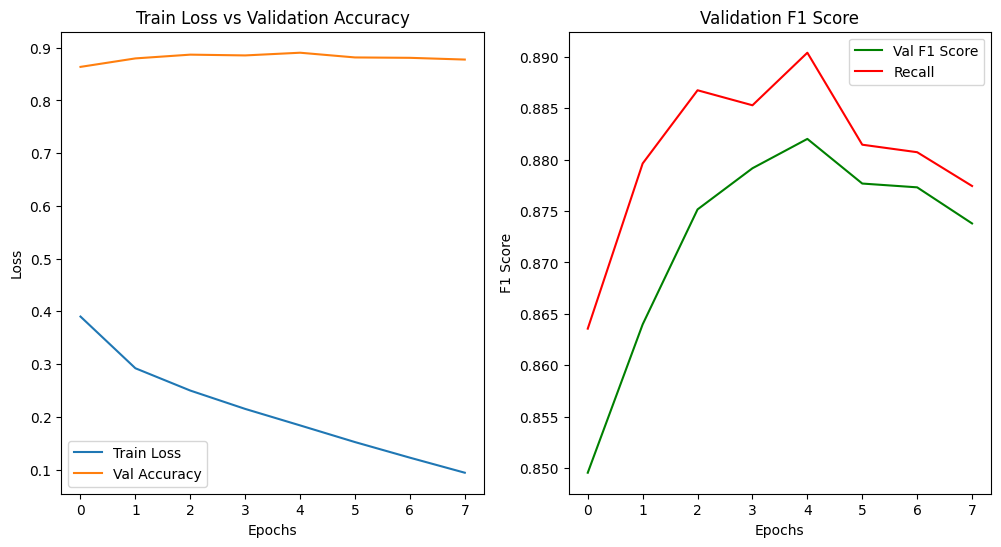

Validation Accuracy: 0.8774, F1: 0.8738, Recall: 0.8774
Training with hidden_dim=64, embed_size=50, lr=0.0005, batch_size=16
Epoch [1/10], Train Loss: 0.4004, Train Accuracy: 0.8372, Val Loss: 0.3416, Val Accuracy: 0.8628, Val F1: 0.8474, Val Recall: 0.8628
Epoch [2/10], Train Loss: 0.3013, Train Accuracy: 0.8802, Val Loss: 0.3145, Val Accuracy: 0.8782, Val F1: 0.8632, Val Recall: 0.8782
Epoch [3/10], Train Loss: 0.2606, Train Accuracy: 0.8986, Val Loss: 0.3115, Val Accuracy: 0.8789, Val F1: 0.8686, Val Recall: 0.8789
Epoch [4/10], Train Loss: 0.2283, Train Accuracy: 0.9113, Val Loss: 0.3151, Val Accuracy: 0.8785, Val F1: 0.8712, Val Recall: 0.8785
Epoch [5/10], Train Loss: 0.1997, Train Accuracy: 0.9238, Val Loss: 0.3115, Val Accuracy: 0.8869, Val F1: 0.8759, Val Recall: 0.8869
Epoch [6/10], Train Loss: 0.1715, Train Accuracy: 0.9354, Val Loss: 0.3393, Val Accuracy: 0.8789, Val F1: 0.8723, Val Recall: 0.8789
Epoch [7/10], Train Loss: 0.1450, Train Accuracy: 0.9457, Val Loss: 0.3499, V

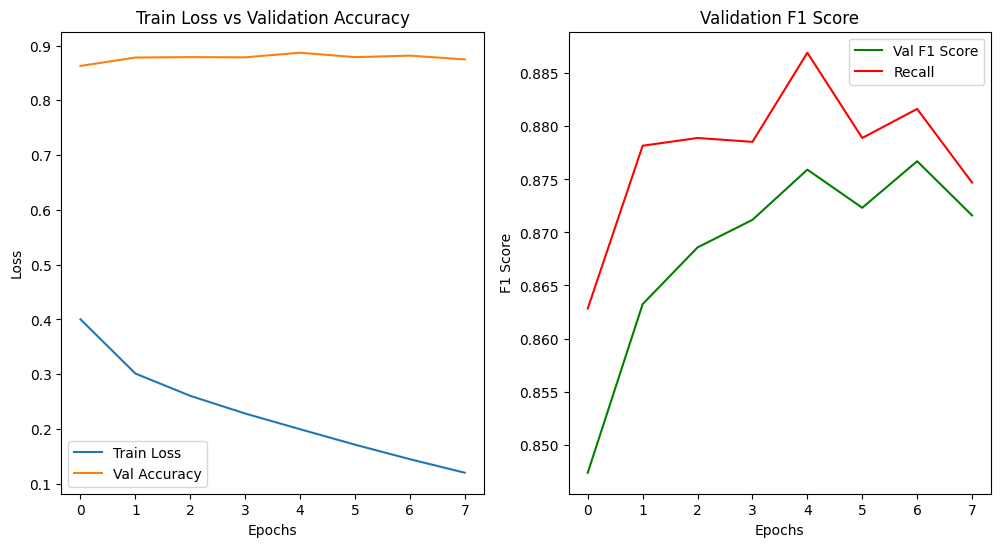

Validation Accuracy: 0.8747, F1: 0.8716, Recall: 0.8747
Training with hidden_dim=64, embed_size=50, lr=0.001, batch_size=8
Epoch [1/10], Train Loss: 0.3825, Train Accuracy: 0.8459, Val Loss: 0.3251, Val Accuracy: 0.8736, Val F1: 0.8586, Val Recall: 0.8736
Epoch [2/10], Train Loss: 0.2843, Train Accuracy: 0.8857, Val Loss: 0.3082, Val Accuracy: 0.8809, Val F1: 0.8613, Val Recall: 0.8809
Epoch [3/10], Train Loss: 0.2349, Train Accuracy: 0.9070, Val Loss: 0.3275, Val Accuracy: 0.8869, Val F1: 0.8737, Val Recall: 0.8869
Epoch [4/10], Train Loss: 0.1922, Train Accuracy: 0.9261, Val Loss: 0.3102, Val Accuracy: 0.8838, Val F1: 0.8758, Val Recall: 0.8838
Epoch [5/10], Train Loss: 0.1508, Train Accuracy: 0.9429, Val Loss: 0.3341, Val Accuracy: 0.8818, Val F1: 0.8762, Val Recall: 0.8818
Epoch [6/10], Train Loss: 0.1112, Train Accuracy: 0.9598, Val Loss: 0.4106, Val Accuracy: 0.8840, Val F1: 0.8753, Val Recall: 0.8840
Training stopped due to patience limit.


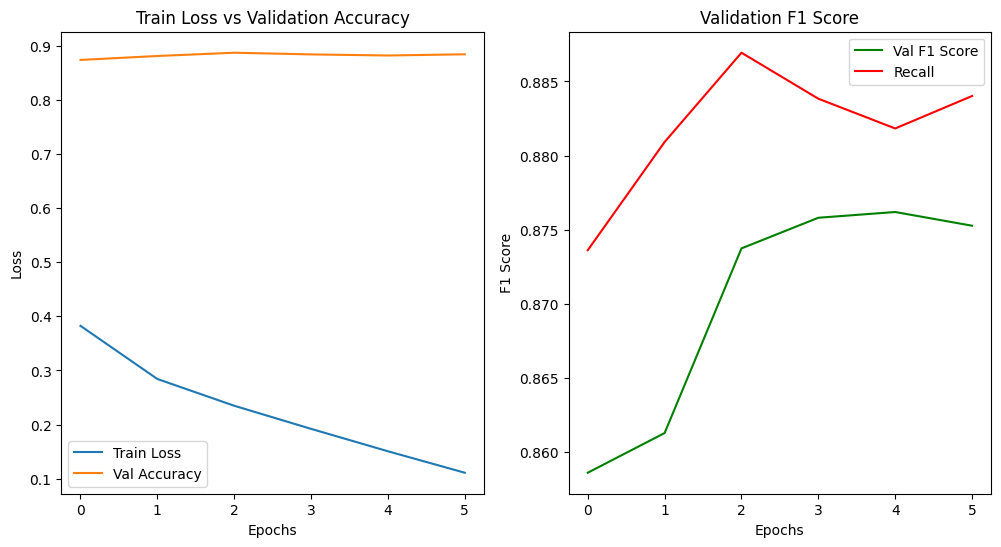

Validation Accuracy: 0.8840, F1: 0.8753, Recall: 0.8840
Training with hidden_dim=64, embed_size=50, lr=0.001, batch_size=16
Epoch [1/10], Train Loss: 0.3853, Train Accuracy: 0.8449, Val Loss: 0.3290, Val Accuracy: 0.8658, Val F1: 0.8540, Val Recall: 0.8658
Epoch [2/10], Train Loss: 0.2802, Train Accuracy: 0.8905, Val Loss: 0.2973, Val Accuracy: 0.8835, Val F1: 0.8733, Val Recall: 0.8835
Epoch [3/10], Train Loss: 0.2365, Train Accuracy: 0.9089, Val Loss: 0.3016, Val Accuracy: 0.8911, Val F1: 0.8799, Val Recall: 0.8911
Epoch [4/10], Train Loss: 0.1989, Train Accuracy: 0.9233, Val Loss: 0.3033, Val Accuracy: 0.8844, Val F1: 0.8814, Val Recall: 0.8844
Epoch [5/10], Train Loss: 0.1641, Train Accuracy: 0.9388, Val Loss: 0.3373, Val Accuracy: 0.8910, Val F1: 0.8805, Val Recall: 0.8910
Epoch [6/10], Train Loss: 0.1286, Train Accuracy: 0.9536, Val Loss: 0.3637, Val Accuracy: 0.8853, Val F1: 0.8799, Val Recall: 0.8853
Training stopped due to patience limit.


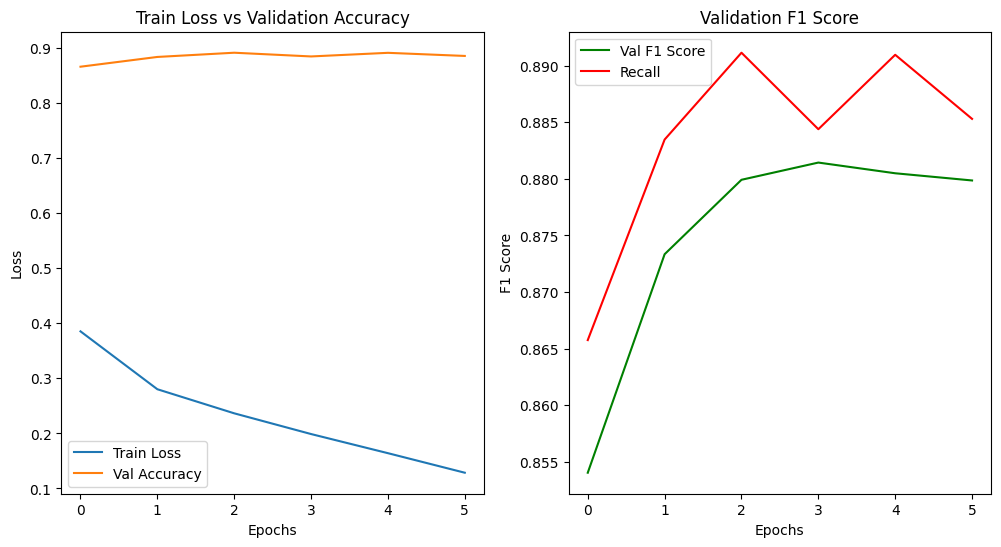

Validation Accuracy: 0.8853, F1: 0.8799, Recall: 0.8853
Training with hidden_dim=64, embed_size=50, lr=0.01, batch_size=8
Epoch [1/10], Train Loss: 0.3813, Train Accuracy: 0.8470, Val Loss: 0.3334, Val Accuracy: 0.8700, Val F1: 0.8617, Val Recall: 0.8700
Epoch [2/10], Train Loss: 0.3260, Train Accuracy: 0.8734, Val Loss: 0.3462, Val Accuracy: 0.8683, Val F1: 0.8448, Val Recall: 0.8683
Epoch [3/10], Train Loss: 0.3024, Train Accuracy: 0.8799, Val Loss: 0.3335, Val Accuracy: 0.8762, Val F1: 0.8645, Val Recall: 0.8762
Epoch [4/10], Train Loss: 0.3052, Train Accuracy: 0.8809, Val Loss: 0.3530, Val Accuracy: 0.8740, Val F1: 0.8572, Val Recall: 0.8740
Epoch [5/10], Train Loss: 0.3003, Train Accuracy: 0.8820, Val Loss: 0.3557, Val Accuracy: 0.8614, Val F1: 0.8518, Val Recall: 0.8614
Epoch [6/10], Train Loss: 0.2929, Train Accuracy: 0.8860, Val Loss: 0.3616, Val Accuracy: 0.8577, Val F1: 0.8547, Val Recall: 0.8577
Training stopped due to patience limit.


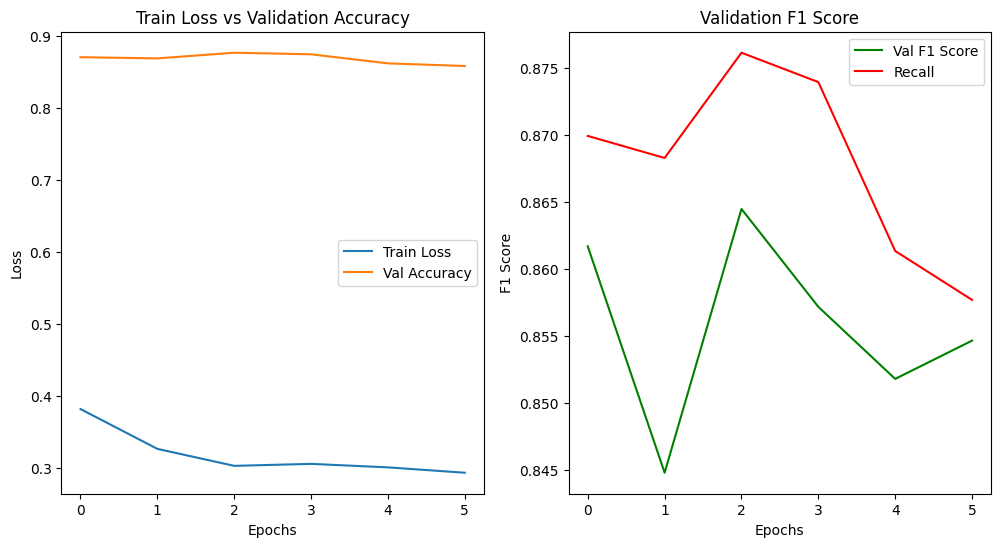

Validation Accuracy: 0.8577, F1: 0.8547, Recall: 0.8577
Training with hidden_dim=64, embed_size=50, lr=0.01, batch_size=16
Epoch [1/10], Train Loss: 0.3586, Train Accuracy: 0.8578, Val Loss: 0.3310, Val Accuracy: 0.8763, Val F1: 0.8656, Val Recall: 0.8763
Epoch [2/10], Train Loss: 0.2895, Train Accuracy: 0.8863, Val Loss: 0.3154, Val Accuracy: 0.8784, Val F1: 0.8627, Val Recall: 0.8784
Epoch [3/10], Train Loss: 0.2670, Train Accuracy: 0.8962, Val Loss: 0.3252, Val Accuracy: 0.8840, Val F1: 0.8709, Val Recall: 0.8840
Epoch [4/10], Train Loss: 0.2540, Train Accuracy: 0.9023, Val Loss: 0.3308, Val Accuracy: 0.8763, Val F1: 0.8602, Val Recall: 0.8763
Epoch [5/10], Train Loss: 0.2477, Train Accuracy: 0.9041, Val Loss: 0.3379, Val Accuracy: 0.8769, Val F1: 0.8692, Val Recall: 0.8769
Epoch [6/10], Train Loss: 0.2502, Train Accuracy: 0.9017, Val Loss: 0.3472, Val Accuracy: 0.8718, Val F1: 0.8652, Val Recall: 0.8718
Training stopped due to patience limit.


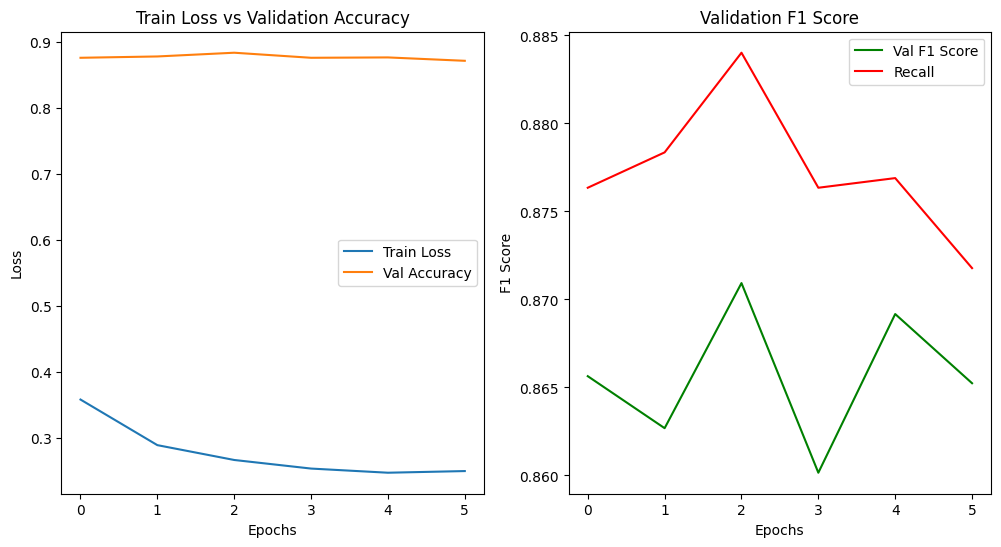

Validation Accuracy: 0.8718, F1: 0.8652, Recall: 0.8718
Training with hidden_dim=64, embed_size=100, lr=0.0005, batch_size=8
Epoch [1/10], Train Loss: 0.3669, Train Accuracy: 0.8520, Val Loss: 0.3248, Val Accuracy: 0.8727, Val F1: 0.8615, Val Recall: 0.8727
Epoch [2/10], Train Loss: 0.2707, Train Accuracy: 0.8948, Val Loss: 0.3007, Val Accuracy: 0.8831, Val F1: 0.8697, Val Recall: 0.8831
Epoch [3/10], Train Loss: 0.2214, Train Accuracy: 0.9150, Val Loss: 0.2948, Val Accuracy: 0.8886, Val F1: 0.8804, Val Recall: 0.8886
Epoch [4/10], Train Loss: 0.1766, Train Accuracy: 0.9327, Val Loss: 0.3228, Val Accuracy: 0.8889, Val F1: 0.8825, Val Recall: 0.8889
Epoch [5/10], Train Loss: 0.1362, Train Accuracy: 0.9497, Val Loss: 0.3498, Val Accuracy: 0.8862, Val F1: 0.8814, Val Recall: 0.8862
Epoch [6/10], Train Loss: 0.0988, Train Accuracy: 0.9656, Val Loss: 0.4126, Val Accuracy: 0.8877, Val F1: 0.8783, Val Recall: 0.8877
Epoch [7/10], Train Loss: 0.0699, Train Accuracy: 0.9763, Val Loss: 0.4552, V

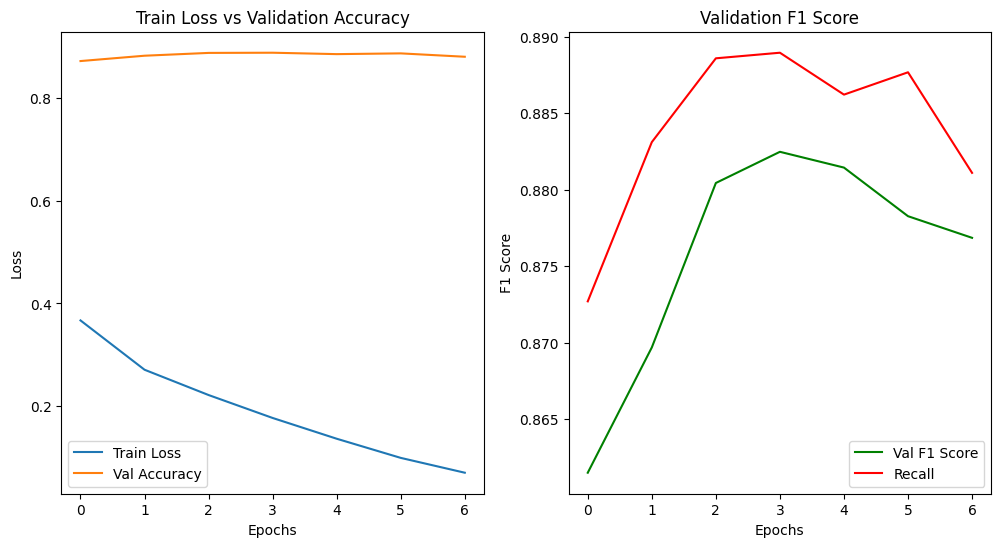

Validation Accuracy: 0.8811, F1: 0.8768, Recall: 0.8811
Training with hidden_dim=64, embed_size=100, lr=0.0005, batch_size=16
Epoch [1/10], Train Loss: 0.3757, Train Accuracy: 0.8489, Val Loss: 0.3289, Val Accuracy: 0.8736, Val F1: 0.8520, Val Recall: 0.8736
Epoch [2/10], Train Loss: 0.2775, Train Accuracy: 0.8907, Val Loss: 0.3053, Val Accuracy: 0.8837, Val F1: 0.8746, Val Recall: 0.8837
Epoch [3/10], Train Loss: 0.2293, Train Accuracy: 0.9110, Val Loss: 0.3003, Val Accuracy: 0.8869, Val F1: 0.8756, Val Recall: 0.8869
Epoch [4/10], Train Loss: 0.1875, Train Accuracy: 0.9284, Val Loss: 0.3079, Val Accuracy: 0.8899, Val F1: 0.8814, Val Recall: 0.8899
Epoch [5/10], Train Loss: 0.1500, Train Accuracy: 0.9440, Val Loss: 0.3461, Val Accuracy: 0.8882, Val F1: 0.8796, Val Recall: 0.8882
Epoch [6/10], Train Loss: 0.1168, Train Accuracy: 0.9578, Val Loss: 0.3937, Val Accuracy: 0.8866, Val F1: 0.8780, Val Recall: 0.8866
Epoch [7/10], Train Loss: 0.0885, Train Accuracy: 0.9688, Val Loss: 0.3921, 

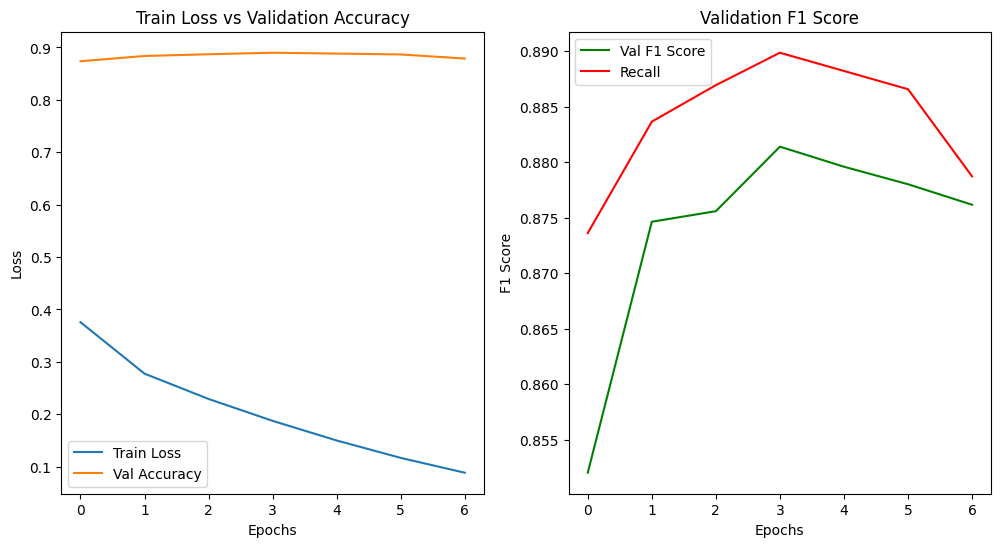

Validation Accuracy: 0.8787, F1: 0.8762, Recall: 0.8787
Training with hidden_dim=64, embed_size=100, lr=0.001, batch_size=8
Epoch [1/10], Train Loss: 0.3597, Train Accuracy: 0.8555, Val Loss: 0.3170, Val Accuracy: 0.8774, Val F1: 0.8588, Val Recall: 0.8774
Epoch [2/10], Train Loss: 0.2604, Train Accuracy: 0.8979, Val Loss: 0.2908, Val Accuracy: 0.8908, Val F1: 0.8820, Val Recall: 0.8908
Epoch [3/10], Train Loss: 0.2086, Train Accuracy: 0.9204, Val Loss: 0.2937, Val Accuracy: 0.8862, Val F1: 0.8785, Val Recall: 0.8862
Epoch [4/10], Train Loss: 0.1525, Train Accuracy: 0.9424, Val Loss: 0.3359, Val Accuracy: 0.8932, Val F1: 0.8837, Val Recall: 0.8932
Epoch [5/10], Train Loss: 0.1005, Train Accuracy: 0.9648, Val Loss: 0.3871, Val Accuracy: 0.8751, Val F1: 0.8744, Val Recall: 0.8751
Epoch [6/10], Train Loss: 0.0604, Train Accuracy: 0.9797, Val Loss: 0.4577, Val Accuracy: 0.8813, Val F1: 0.8783, Val Recall: 0.8813
Epoch [7/10], Train Loss: 0.0339, Train Accuracy: 0.9891, Val Loss: 0.5356, Va

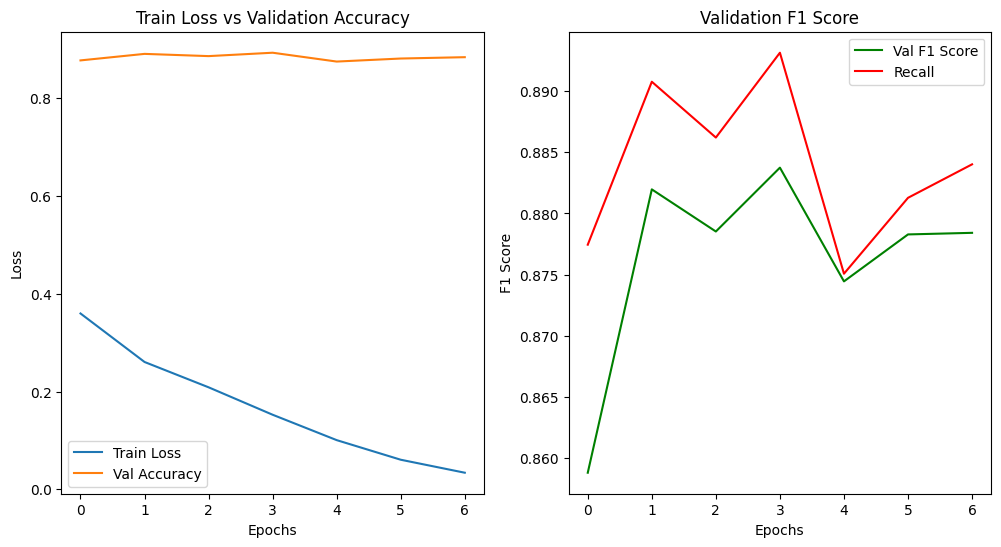

Validation Accuracy: 0.8840, F1: 0.8784, Recall: 0.8840
Training with hidden_dim=64, embed_size=100, lr=0.001, batch_size=16
Epoch [1/10], Train Loss: 0.3631, Train Accuracy: 0.8522, Val Loss: 0.3168, Val Accuracy: 0.8776, Val F1: 0.8613, Val Recall: 0.8776
Epoch [2/10], Train Loss: 0.2626, Train Accuracy: 0.8969, Val Loss: 0.2967, Val Accuracy: 0.8807, Val F1: 0.8637, Val Recall: 0.8807
Epoch [3/10], Train Loss: 0.2085, Train Accuracy: 0.9185, Val Loss: 0.3042, Val Accuracy: 0.8882, Val F1: 0.8812, Val Recall: 0.8882
Epoch [4/10], Train Loss: 0.1579, Train Accuracy: 0.9393, Val Loss: 0.3053, Val Accuracy: 0.8877, Val F1: 0.8828, Val Recall: 0.8877
Epoch [5/10], Train Loss: 0.1129, Train Accuracy: 0.9590, Val Loss: 0.3564, Val Accuracy: 0.8840, Val F1: 0.8792, Val Recall: 0.8840
Epoch [6/10], Train Loss: 0.0784, Train Accuracy: 0.9716, Val Loss: 0.4296, Val Accuracy: 0.8805, Val F1: 0.8739, Val Recall: 0.8805
Training stopped due to patience limit.


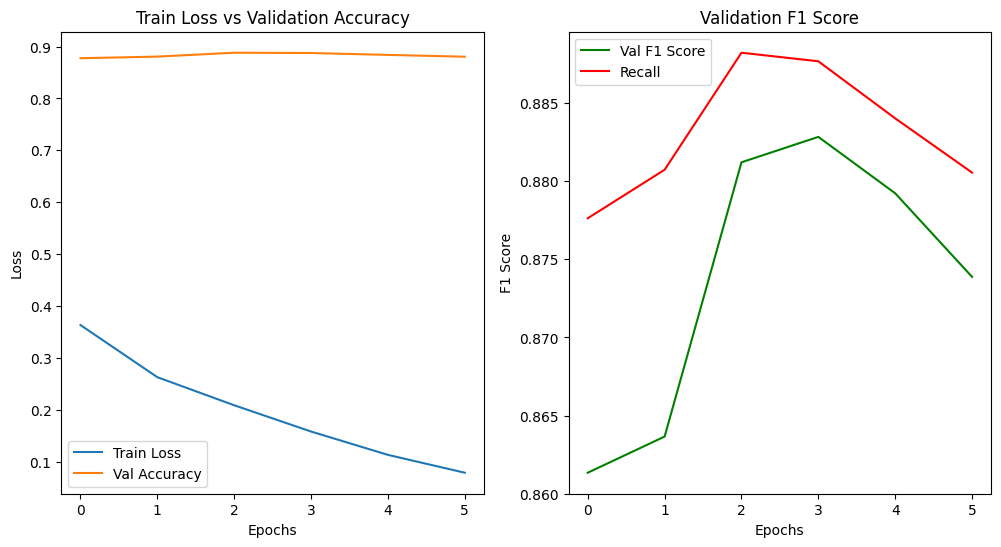

Validation Accuracy: 0.8805, F1: 0.8739, Recall: 0.8805
Training with hidden_dim=64, embed_size=100, lr=0.01, batch_size=8
Epoch [1/10], Train Loss: 0.3914, Train Accuracy: 0.8472, Val Loss: 0.3745, Val Accuracy: 0.8572, Val F1: 0.8354, Val Recall: 0.8572
Epoch [2/10], Train Loss: 0.3402, Train Accuracy: 0.8639, Val Loss: 0.3782, Val Accuracy: 0.8506, Val F1: 0.8348, Val Recall: 0.8506
Epoch [3/10], Train Loss: 0.3229, Train Accuracy: 0.8731, Val Loss: 0.3801, Val Accuracy: 0.8621, Val F1: 0.8332, Val Recall: 0.8621
Epoch [4/10], Train Loss: 0.3194, Train Accuracy: 0.8753, Val Loss: 0.3751, Val Accuracy: 0.8574, Val F1: 0.8417, Val Recall: 0.8574
Epoch [5/10], Train Loss: 0.3115, Train Accuracy: 0.8766, Val Loss: 0.3865, Val Accuracy: 0.8541, Val F1: 0.8356, Val Recall: 0.8541
Epoch [6/10], Train Loss: 0.3034, Train Accuracy: 0.8798, Val Loss: 0.3677, Val Accuracy: 0.8533, Val F1: 0.8380, Val Recall: 0.8533
Training stopped due to patience limit.


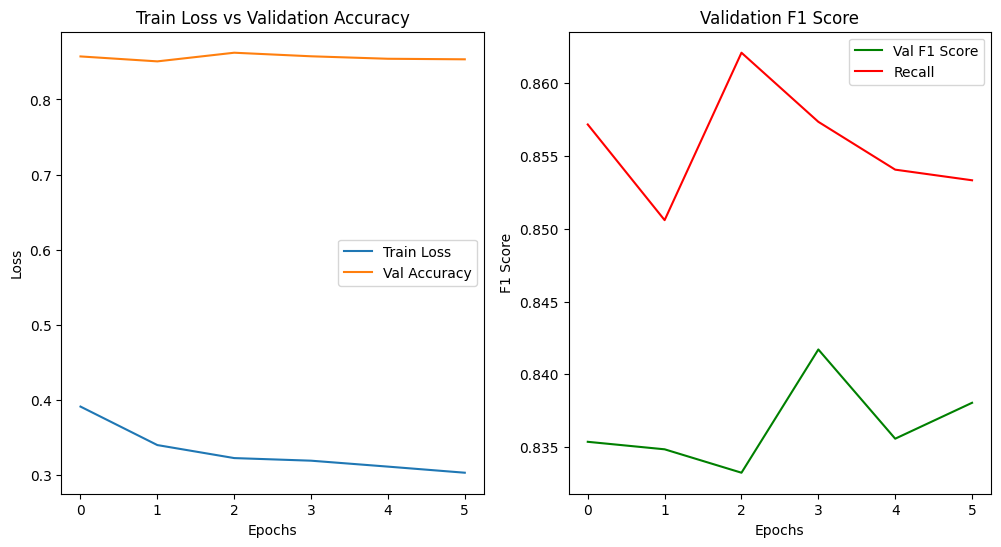

Validation Accuracy: 0.8533, F1: 0.8380, Recall: 0.8533
Training with hidden_dim=64, embed_size=100, lr=0.01, batch_size=16
Epoch [1/10], Train Loss: 0.3586, Train Accuracy: 0.8574, Val Loss: 0.3208, Val Accuracy: 0.8718, Val F1: 0.8627, Val Recall: 0.8718
Epoch [2/10], Train Loss: 0.2972, Train Accuracy: 0.8836, Val Loss: 0.3327, Val Accuracy: 0.8597, Val F1: 0.8558, Val Recall: 0.8597
Epoch [3/10], Train Loss: 0.2786, Train Accuracy: 0.8904, Val Loss: 0.3466, Val Accuracy: 0.8705, Val F1: 0.8635, Val Recall: 0.8705
Epoch [4/10], Train Loss: 0.2775, Train Accuracy: 0.8908, Val Loss: 0.3436, Val Accuracy: 0.8665, Val F1: 0.8556, Val Recall: 0.8665
Training stopped due to patience limit.


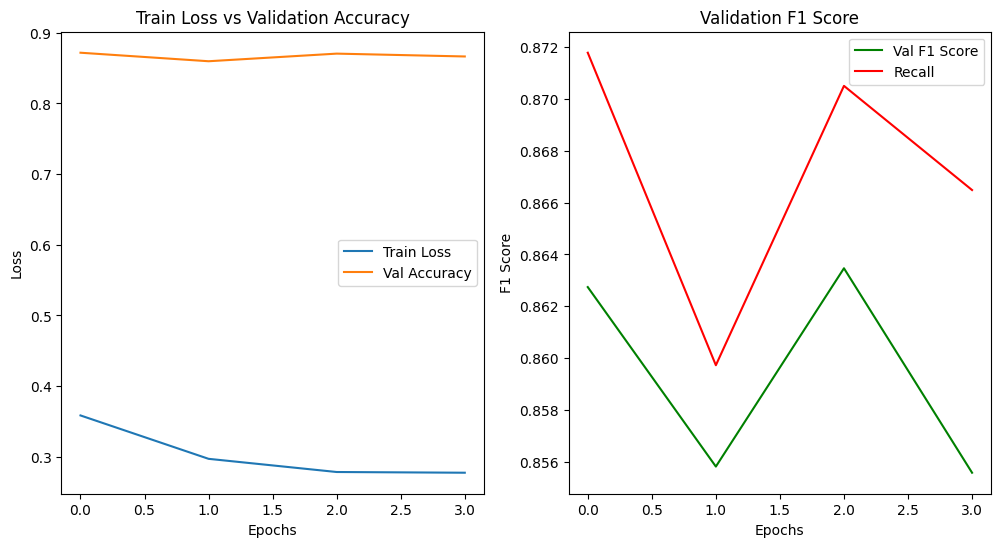

Validation Accuracy: 0.8665, F1: 0.8556, Recall: 0.8665
Training with hidden_dim=128, embed_size=50, lr=0.0005, batch_size=8
Epoch [1/10], Train Loss: 0.3944, Train Accuracy: 0.8412, Val Loss: 0.3461, Val Accuracy: 0.8626, Val F1: 0.8301, Val Recall: 0.8626
Epoch [2/10], Train Loss: 0.2999, Train Accuracy: 0.8816, Val Loss: 0.3055, Val Accuracy: 0.8760, Val F1: 0.8659, Val Recall: 0.8760
Epoch [3/10], Train Loss: 0.2569, Train Accuracy: 0.8998, Val Loss: 0.3113, Val Accuracy: 0.8851, Val F1: 0.8730, Val Recall: 0.8851
Epoch [4/10], Train Loss: 0.2187, Train Accuracy: 0.9152, Val Loss: 0.3044, Val Accuracy: 0.8906, Val F1: 0.8796, Val Recall: 0.8906
Epoch [5/10], Train Loss: 0.1807, Train Accuracy: 0.9307, Val Loss: 0.3193, Val Accuracy: 0.8869, Val F1: 0.8802, Val Recall: 0.8869
Epoch [6/10], Train Loss: 0.1373, Train Accuracy: 0.9485, Val Loss: 0.3428, Val Accuracy: 0.8811, Val F1: 0.8771, Val Recall: 0.8811
Epoch [7/10], Train Loss: 0.0946, Train Accuracy: 0.9652, Val Loss: 0.3874, V

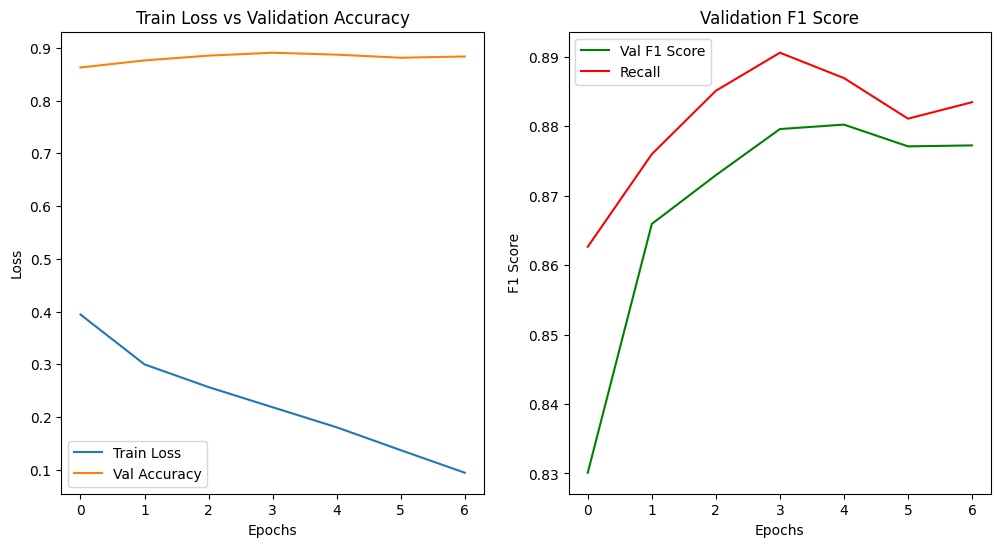

Validation Accuracy: 0.8835, F1: 0.8772, Recall: 0.8835
Training with hidden_dim=128, embed_size=50, lr=0.0005, batch_size=16
Epoch [1/10], Train Loss: 0.4021, Train Accuracy: 0.8347, Val Loss: 0.3514, Val Accuracy: 0.8650, Val F1: 0.8433, Val Recall: 0.8650
Epoch [2/10], Train Loss: 0.3110, Train Accuracy: 0.8755, Val Loss: 0.3229, Val Accuracy: 0.8736, Val F1: 0.8570, Val Recall: 0.8736
Epoch [3/10], Train Loss: 0.2675, Train Accuracy: 0.8931, Val Loss: 0.3184, Val Accuracy: 0.8754, Val F1: 0.8551, Val Recall: 0.8754
Epoch [4/10], Train Loss: 0.2293, Train Accuracy: 0.9104, Val Loss: 0.3125, Val Accuracy: 0.8816, Val F1: 0.8738, Val Recall: 0.8816
Epoch [5/10], Train Loss: 0.1973, Train Accuracy: 0.9238, Val Loss: 0.3246, Val Accuracy: 0.8676, Val F1: 0.8680, Val Recall: 0.8676
Epoch [6/10], Train Loss: 0.1640, Train Accuracy: 0.9371, Val Loss: 0.3312, Val Accuracy: 0.8835, Val F1: 0.8777, Val Recall: 0.8835
Epoch [7/10], Train Loss: 0.1278, Train Accuracy: 0.9521, Val Loss: 0.3640, 

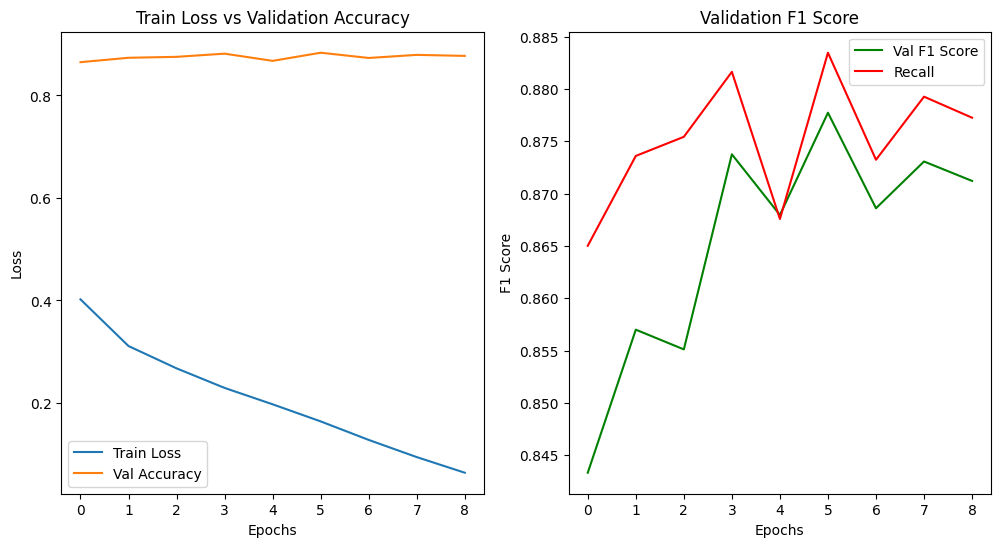

Validation Accuracy: 0.8773, F1: 0.8712, Recall: 0.8773
Training with hidden_dim=128, embed_size=50, lr=0.001, batch_size=8
Epoch [1/10], Train Loss: 0.3729, Train Accuracy: 0.8506, Val Loss: 0.3294, Val Accuracy: 0.8714, Val F1: 0.8475, Val Recall: 0.8714
Epoch [2/10], Train Loss: 0.2718, Train Accuracy: 0.8921, Val Loss: 0.3173, Val Accuracy: 0.8853, Val F1: 0.8744, Val Recall: 0.8853
Epoch [3/10], Train Loss: 0.2222, Train Accuracy: 0.9128, Val Loss: 0.2866, Val Accuracy: 0.8897, Val F1: 0.8816, Val Recall: 0.8897
Epoch [4/10], Train Loss: 0.1746, Train Accuracy: 0.9324, Val Loss: 0.3052, Val Accuracy: 0.8864, Val F1: 0.8822, Val Recall: 0.8864
Epoch [5/10], Train Loss: 0.1203, Train Accuracy: 0.9553, Val Loss: 0.3577, Val Accuracy: 0.8880, Val F1: 0.8820, Val Recall: 0.8880
Epoch [6/10], Train Loss: 0.0700, Train Accuracy: 0.9748, Val Loss: 0.4575, Val Accuracy: 0.8804, Val F1: 0.8758, Val Recall: 0.8804
Training stopped due to patience limit.


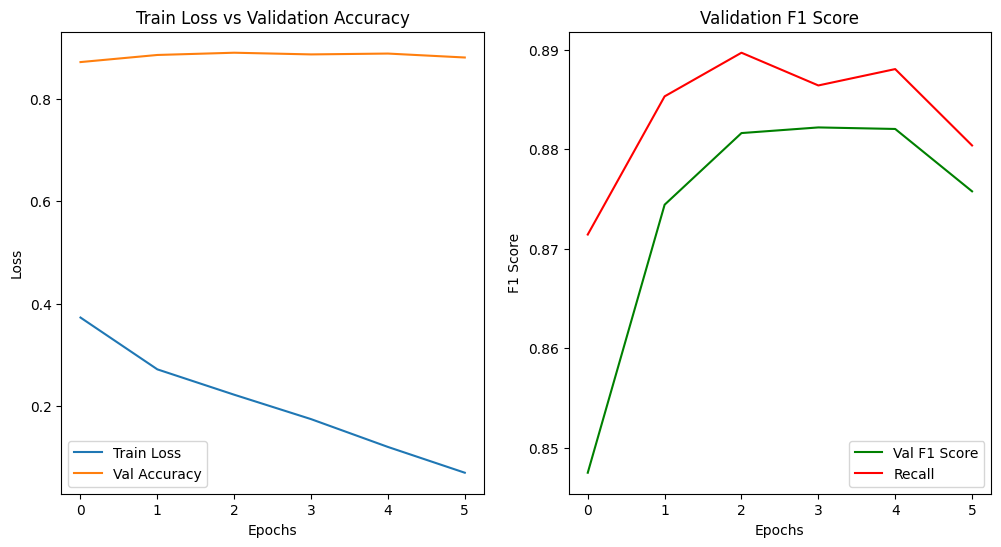

Validation Accuracy: 0.8804, F1: 0.8758, Recall: 0.8804
Training with hidden_dim=128, embed_size=50, lr=0.001, batch_size=16
Epoch [1/10], Train Loss: 0.3938, Train Accuracy: 0.8391, Val Loss: 0.3366, Val Accuracy: 0.8692, Val F1: 0.8403, Val Recall: 0.8692
Epoch [2/10], Train Loss: 0.2852, Train Accuracy: 0.8867, Val Loss: 0.3018, Val Accuracy: 0.8862, Val F1: 0.8749, Val Recall: 0.8862
Epoch [3/10], Train Loss: 0.2385, Train Accuracy: 0.9083, Val Loss: 0.3005, Val Accuracy: 0.8893, Val F1: 0.8777, Val Recall: 0.8893
Epoch [4/10], Train Loss: 0.1968, Train Accuracy: 0.9240, Val Loss: 0.3052, Val Accuracy: 0.8862, Val F1: 0.8754, Val Recall: 0.8862
Epoch [5/10], Train Loss: 0.1492, Train Accuracy: 0.9432, Val Loss: 0.3375, Val Accuracy: 0.8840, Val F1: 0.8807, Val Recall: 0.8840
Epoch [6/10], Train Loss: 0.1005, Train Accuracy: 0.9628, Val Loss: 0.4052, Val Accuracy: 0.8734, Val F1: 0.8725, Val Recall: 0.8734
Training stopped due to patience limit.


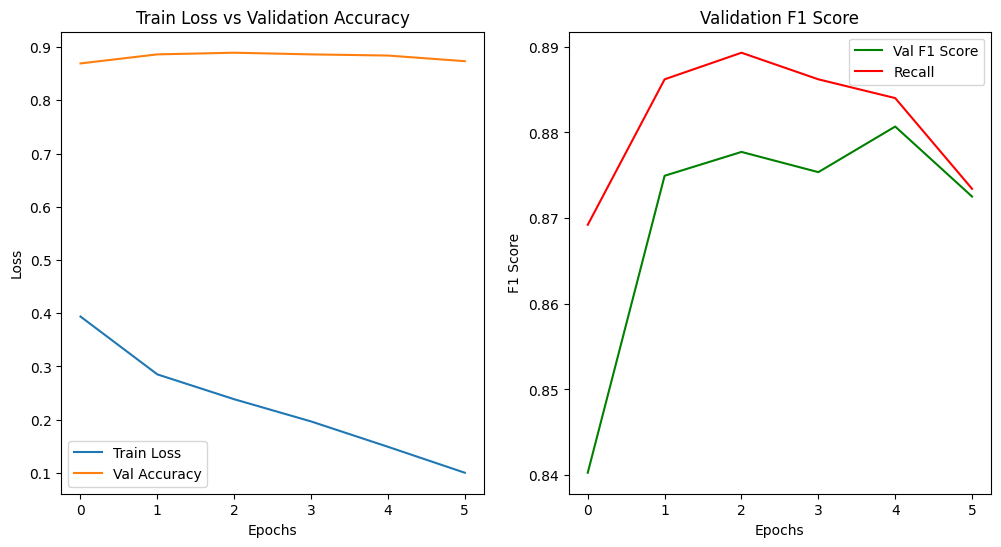

Validation Accuracy: 0.8734, F1: 0.8725, Recall: 0.8734
Training with hidden_dim=128, embed_size=50, lr=0.01, batch_size=8
Epoch [1/10], Train Loss: 0.3857, Train Accuracy: 0.8468, Val Loss: 0.3729, Val Accuracy: 0.8681, Val F1: 0.8481, Val Recall: 0.8681
Epoch [2/10], Train Loss: 0.3561, Train Accuracy: 0.8598, Val Loss: 0.4220, Val Accuracy: 0.8342, Val F1: 0.8215, Val Recall: 0.8342
Epoch [3/10], Train Loss: 0.4481, Train Accuracy: 0.8211, Val Loss: 0.4598, Val Accuracy: 0.8340, Val F1: 0.8005, Val Recall: 0.8340
Epoch [4/10], Train Loss: 0.4667, Train Accuracy: 0.8154, Val Loss: 0.4750, Val Accuracy: 0.8044, Val F1: 0.7847, Val Recall: 0.8044
Training stopped due to patience limit.


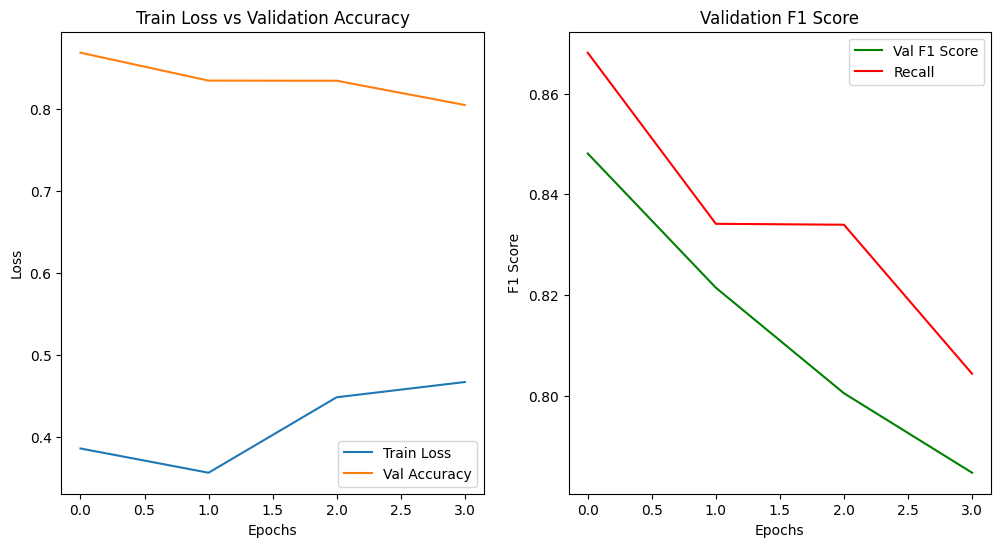

Validation Accuracy: 0.8044, F1: 0.7847, Recall: 0.8044
Training with hidden_dim=128, embed_size=50, lr=0.01, batch_size=16
Epoch [1/10], Train Loss: 0.3640, Train Accuracy: 0.8576, Val Loss: 0.3556, Val Accuracy: 0.8577, Val F1: 0.8570, Val Recall: 0.8577
Epoch [2/10], Train Loss: 0.2948, Train Accuracy: 0.8845, Val Loss: 0.3301, Val Accuracy: 0.8804, Val F1: 0.8667, Val Recall: 0.8804
Epoch [3/10], Train Loss: 0.2795, Train Accuracy: 0.8906, Val Loss: 0.3253, Val Accuracy: 0.8738, Val F1: 0.8672, Val Recall: 0.8738
Epoch [4/10], Train Loss: 0.2674, Train Accuracy: 0.8954, Val Loss: 0.3469, Val Accuracy: 0.8678, Val F1: 0.8519, Val Recall: 0.8678
Epoch [5/10], Train Loss: 0.2703, Train Accuracy: 0.8962, Val Loss: 0.3819, Val Accuracy: 0.8557, Val F1: 0.8537, Val Recall: 0.8557
Training stopped due to patience limit.


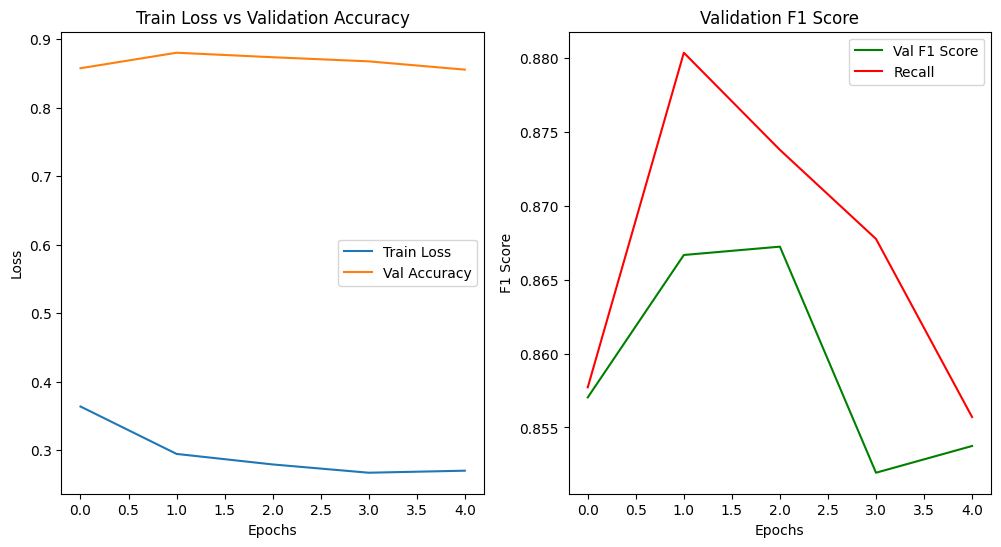

Validation Accuracy: 0.8557, F1: 0.8537, Recall: 0.8557
Training with hidden_dim=128, embed_size=100, lr=0.0005, batch_size=8
Epoch [1/10], Train Loss: 0.3894, Train Accuracy: 0.8432, Val Loss: 0.3367, Val Accuracy: 0.8705, Val F1: 0.8475, Val Recall: 0.8705
Epoch [2/10], Train Loss: 0.2910, Train Accuracy: 0.8843, Val Loss: 0.3189, Val Accuracy: 0.8685, Val F1: 0.8646, Val Recall: 0.8685
Epoch [3/10], Train Loss: 0.2400, Train Accuracy: 0.9070, Val Loss: 0.2980, Val Accuracy: 0.8915, Val F1: 0.8796, Val Recall: 0.8915
Epoch [4/10], Train Loss: 0.1928, Train Accuracy: 0.9260, Val Loss: 0.3027, Val Accuracy: 0.8857, Val F1: 0.8799, Val Recall: 0.8857
Epoch [5/10], Train Loss: 0.1409, Train Accuracy: 0.9459, Val Loss: 0.3290, Val Accuracy: 0.8899, Val F1: 0.8825, Val Recall: 0.8899
Epoch [6/10], Train Loss: 0.0922, Train Accuracy: 0.9664, Val Loss: 0.3780, Val Accuracy: 0.8815, Val F1: 0.8727, Val Recall: 0.8815
Training stopped due to patience limit.


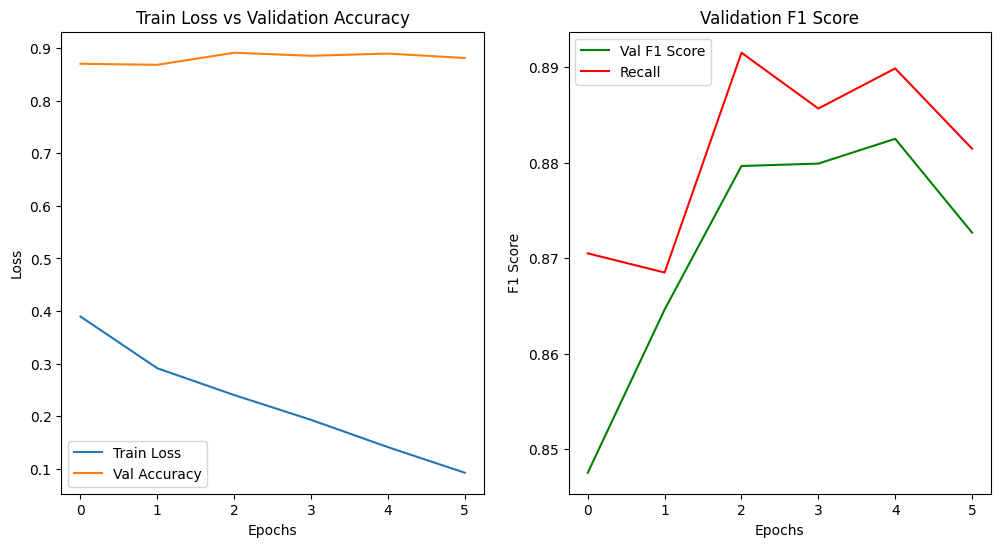

Validation Accuracy: 0.8815, F1: 0.8727, Recall: 0.8815
Training with hidden_dim=128, embed_size=100, lr=0.0005, batch_size=16
Epoch [1/10], Train Loss: 0.3785, Train Accuracy: 0.8466, Val Loss: 0.3312, Val Accuracy: 0.8742, Val F1: 0.8549, Val Recall: 0.8742
Epoch [2/10], Train Loss: 0.2831, Train Accuracy: 0.8885, Val Loss: 0.3201, Val Accuracy: 0.8851, Val F1: 0.8734, Val Recall: 0.8851
Epoch [3/10], Train Loss: 0.2333, Train Accuracy: 0.9087, Val Loss: 0.3136, Val Accuracy: 0.8846, Val F1: 0.8753, Val Recall: 0.8846
Epoch [4/10], Train Loss: 0.1857, Train Accuracy: 0.9290, Val Loss: 0.3184, Val Accuracy: 0.8826, Val F1: 0.8744, Val Recall: 0.8826
Epoch [5/10], Train Loss: 0.1392, Train Accuracy: 0.9471, Val Loss: 0.3371, Val Accuracy: 0.8895, Val F1: 0.8809, Val Recall: 0.8895
Epoch [6/10], Train Loss: 0.0949, Train Accuracy: 0.9658, Val Loss: 0.3931, Val Accuracy: 0.8816, Val F1: 0.8757, Val Recall: 0.8816
Epoch [7/10], Train Loss: 0.0611, Train Accuracy: 0.9788, Val Loss: 0.4637,

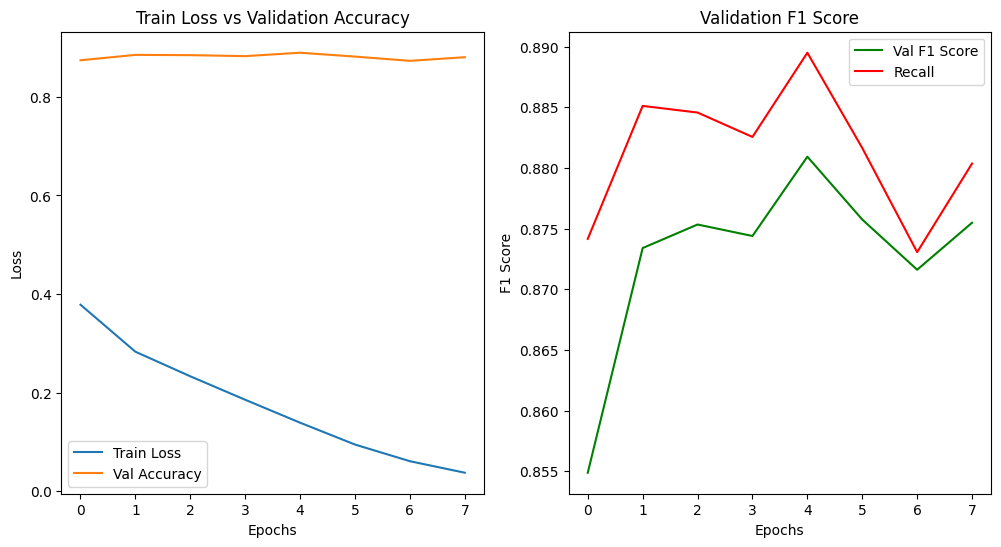

Validation Accuracy: 0.8804, F1: 0.8755, Recall: 0.8804
Training with hidden_dim=128, embed_size=100, lr=0.001, batch_size=8
Epoch [1/10], Train Loss: 0.3689, Train Accuracy: 0.8527, Val Loss: 0.3182, Val Accuracy: 0.8756, Val F1: 0.8523, Val Recall: 0.8756
Epoch [2/10], Train Loss: 0.2716, Train Accuracy: 0.8919, Val Loss: 0.2886, Val Accuracy: 0.8891, Val F1: 0.8787, Val Recall: 0.8891
Epoch [3/10], Train Loss: 0.2139, Train Accuracy: 0.9162, Val Loss: 0.2862, Val Accuracy: 0.8950, Val F1: 0.8830, Val Recall: 0.8950
Epoch [4/10], Train Loss: 0.1537, Train Accuracy: 0.9407, Val Loss: 0.3180, Val Accuracy: 0.8913, Val F1: 0.8830, Val Recall: 0.8913
Epoch [5/10], Train Loss: 0.0877, Train Accuracy: 0.9686, Val Loss: 0.4042, Val Accuracy: 0.8835, Val F1: 0.8793, Val Recall: 0.8835
Epoch [6/10], Train Loss: 0.0451, Train Accuracy: 0.9842, Val Loss: 0.5462, Val Accuracy: 0.8805, Val F1: 0.8766, Val Recall: 0.8805
Training stopped due to patience limit.


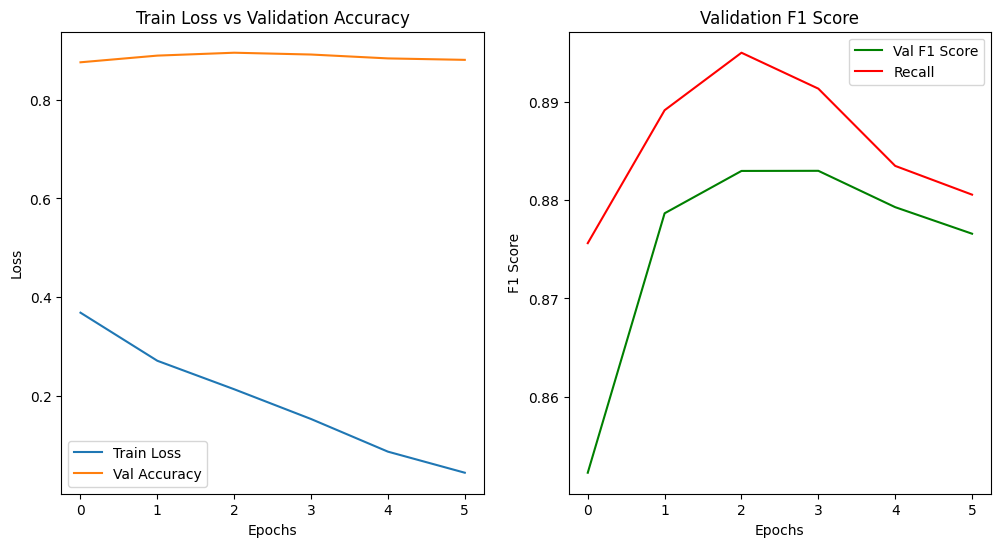

Validation Accuracy: 0.8805, F1: 0.8766, Recall: 0.8805
Training with hidden_dim=128, embed_size=100, lr=0.001, batch_size=16
Epoch [1/10], Train Loss: 0.3613, Train Accuracy: 0.8557, Val Loss: 0.3114, Val Accuracy: 0.8809, Val F1: 0.8701, Val Recall: 0.8809
Epoch [2/10], Train Loss: 0.2615, Train Accuracy: 0.8975, Val Loss: 0.3010, Val Accuracy: 0.8873, Val F1: 0.8767, Val Recall: 0.8873
Epoch [3/10], Train Loss: 0.2020, Train Accuracy: 0.9218, Val Loss: 0.3099, Val Accuracy: 0.8908, Val F1: 0.8829, Val Recall: 0.8908
Epoch [4/10], Train Loss: 0.1439, Train Accuracy: 0.9463, Val Loss: 0.3264, Val Accuracy: 0.8844, Val F1: 0.8797, Val Recall: 0.8844
Epoch [5/10], Train Loss: 0.0840, Train Accuracy: 0.9693, Val Loss: 0.4065, Val Accuracy: 0.8851, Val F1: 0.8813, Val Recall: 0.8851
Epoch [6/10], Train Loss: 0.0426, Train Accuracy: 0.9850, Val Loss: 0.5500, Val Accuracy: 0.8716, Val F1: 0.8696, Val Recall: 0.8716
Training stopped due to patience limit.


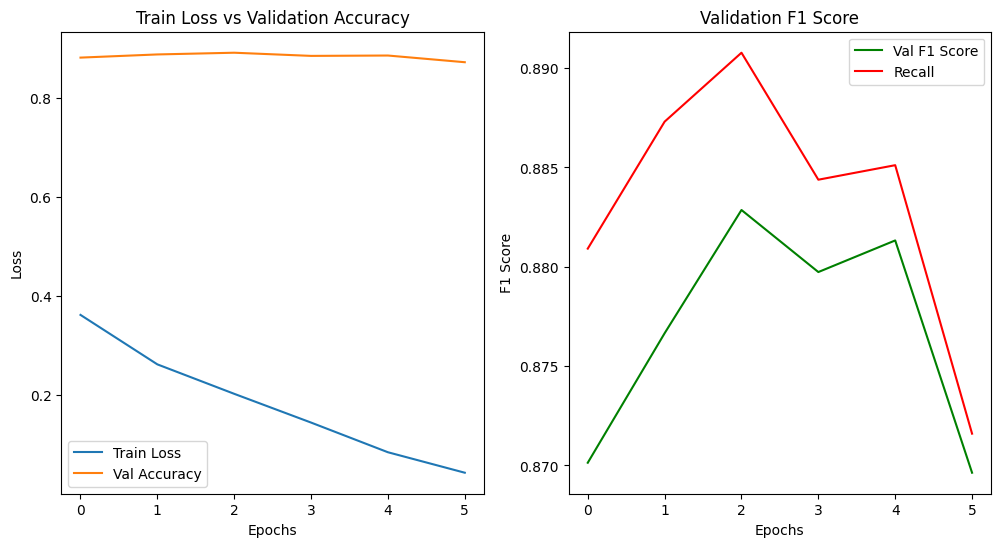

Validation Accuracy: 0.8716, F1: 0.8696, Recall: 0.8716
Training with hidden_dim=128, embed_size=100, lr=0.01, batch_size=8
Epoch [1/10], Train Loss: 0.4232, Train Accuracy: 0.8350, Val Loss: 0.4098, Val Accuracy: 0.8491, Val F1: 0.8241, Val Recall: 0.8491
Epoch [2/10], Train Loss: 0.3928, Train Accuracy: 0.8491, Val Loss: 0.4180, Val Accuracy: 0.8296, Val F1: 0.8263, Val Recall: 0.8296
Epoch [3/10], Train Loss: 0.4004, Train Accuracy: 0.8440, Val Loss: 0.4113, Val Accuracy: 0.8332, Val F1: 0.8208, Val Recall: 0.8332
Epoch [4/10], Train Loss: 0.3885, Train Accuracy: 0.8466, Val Loss: 0.4220, Val Accuracy: 0.8382, Val F1: 0.8175, Val Recall: 0.8382
Training stopped due to patience limit.


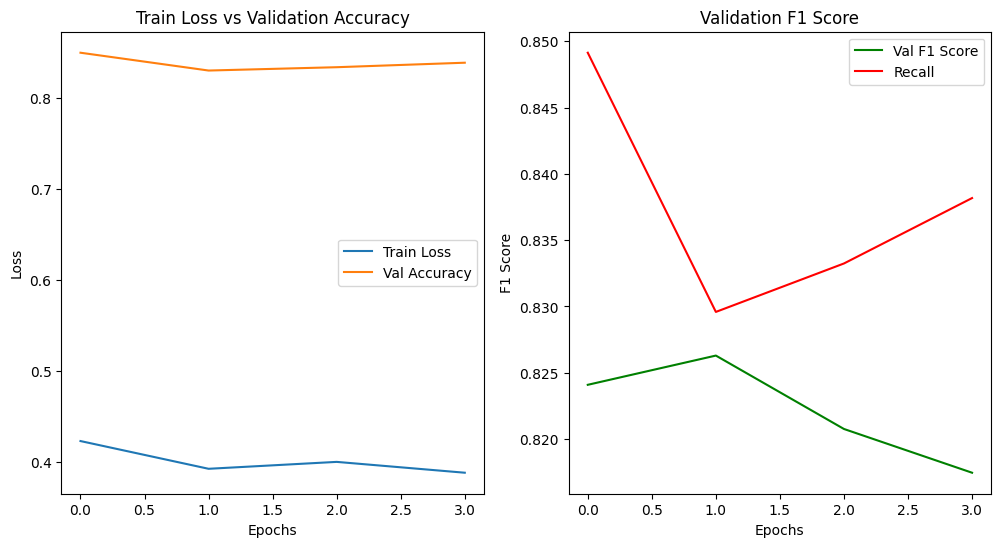

Validation Accuracy: 0.8382, F1: 0.8175, Recall: 0.8382
Training with hidden_dim=128, embed_size=100, lr=0.01, batch_size=16
Epoch [1/10], Train Loss: 0.3836, Train Accuracy: 0.8500, Val Loss: 0.3566, Val Accuracy: 0.8658, Val F1: 0.8411, Val Recall: 0.8658
Epoch [2/10], Train Loss: 0.3290, Train Accuracy: 0.8696, Val Loss: 0.3545, Val Accuracy: 0.8621, Val F1: 0.8478, Val Recall: 0.8621
Epoch [3/10], Train Loss: 0.3303, Train Accuracy: 0.8682, Val Loss: 0.3858, Val Accuracy: 0.8528, Val F1: 0.8298, Val Recall: 0.8528
Epoch [4/10], Train Loss: 0.3222, Train Accuracy: 0.8710, Val Loss: 0.3927, Val Accuracy: 0.8606, Val F1: 0.8333, Val Recall: 0.8606
Training stopped due to patience limit.


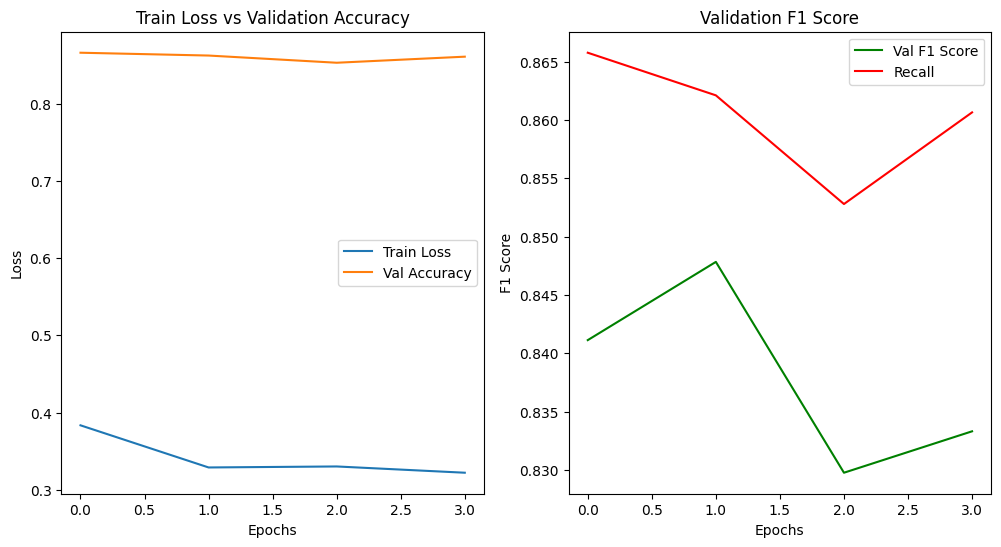

Validation Accuracy: 0.8606, F1: 0.8333, Recall: 0.8606

Best Hyperparameters: Hidden Dim: 64, Embed Size: 50, LR: 0.001, Batch Size: 16
Best Validation Accuracy: 0.8853, F1: 0.8799, Recall: 0.8853


In [ ]:
def random_search(train_loader, val_loader, device, epochs=10):

    hidden_dims = [64, 128]
    embed_sizes = [50, 100]
    learning_rates = [0.0005, 0.001, 0.01]
    batch_sizes = [8, 16]

    best_accuracy = 0.0
    best_f1 = 0.0
    best_recall = 0.0
    best_model = None
    best_params = None


    for hidden_dim in hidden_dims:
        for embed_size in embed_sizes:
            for lr in learning_rates:
                for batch_size in batch_sizes:
                    print(f"Training with hidden_dim={hidden_dim}, embed_size={embed_size}, lr={lr}, batch_size={batch_size}")


                    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
                    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)


                    model = BiLSTMModel(vocab_size=len(vocab), embed_size=embed_size, hidden_size=hidden_dim).to(device)
                    optimizer = optim.Adam(model.parameters(), lr=lr)
                    criterion = nn.CrossEntropyLoss()

                    trained_model = train_and_evaluate(model, train_loader, val_loader, optimizer, criterion, device, epochs=epochs)

                    val_loss, val_accuracy, val_f1, val_recall = evaluate(trained_model, val_loader, criterion, device)


                    if val_accuracy > best_accuracy:
                        best_accuracy = val_accuracy
                        best_f1 = val_f1
                        best_recall = val_recall
                        best_model = trained_model
                        best_params = (hidden_dim, embed_size, lr, batch_size)

                    print(f"Validation Accuracy: {val_accuracy:.4f}, F1: {val_f1:.4f}, Recall: {val_recall:.4f}")

    print(f"\nBest Hyperparameters: Hidden Dim: {best_params[0]}, Embed Size: {best_params[1]}, LR: {best_params[2]}, Batch Size: {best_params[3]}")
    print(f"Best Validation Accuracy: {best_accuracy:.4f}, F1: {best_f1:.4f}, Recall: {best_recall:.4f}")

    return best_model, best_params
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_model, best_params = random_search(train_loader, val_loader, device, epochs=10)

In [ ]:
best_model.eval()
test_correct = 0
test_total = 0
test_preds = []
test_labels_list = []

with torch.no_grad():
    for texts, labels in test_loader:
        texts, labels = texts.to(device), labels.to(device)
        outputs = best_model(texts)
        _, predicted = torch.max(outputs, 1)
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

        test_preds.extend(predicted.cpu().numpy())
        test_labels_list.extend(labels.cpu().numpy())

# Tính accuracy, f1_score và recall
test_acc = test_correct / test_total
test_f1 = f1_score(test_labels_list, test_preds, average='weighted')
test_recall = recall_score(test_labels_list, test_preds, average='weighted')

print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")
print(f"Test Recall: {test_recall:.4f}")

Test Accuracy: 0.9209
Test F1 Score: 0.9191
Test Recall: 0.9209


In [ ]:
import json
def save_best_model_and_params(model, best_params, model_filename='best_model.pth', params_filename='best_params.json'):
    # Lưu mô hình vào tệp
    torch.save(model.state_dict(), model_filename)
    print(f"Model saved to {model_filename}")

    # Lưu các siêu tham số vào tệp JSON
    with open(params_filename, 'w') as f:
        json.dump(best_params, f, indent=4)
    print(f"Best parameters saved to {params_filename}")

# Lưu mô hình tốt nhất và siêu tham số
save_best_model_and_params(best_model, best_params)

Model saved to best_model.pth
Best parameters saved to best_params.json
